<a href="https://colab.research.google.com/github/mannam95/Deep_Learning_Programming/blob/main/%20Assignment5/IDL_ASSIGNMENT_5_govIND.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Team


1.   Govind Shukla (235192)
2.   Meghana Rao (234907)
3.   Srinath Mannam (229750)

###Imports and data downloading

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

###EDA

In [7]:
# remove infrequent words. you can play with this parameter as it will likely impact model quality
num_words = 20000
(train_sequences, train_labels), (test_sequences, test_labels) = tf.keras.datasets.imdb.load_data(num_words=num_words)

In [8]:
train_sequences[:3]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 82

In [9]:
# to restore words, load the word-to-index mapping
word_to_index = tf.keras.datasets.imdb.get_word_index()

1654784/1641221 [==============================] - 0s 0us/step


In [10]:
# invert to get index-to-word mapping
index_to_word = dict((index, word) for (word, index) in word_to_index.items())

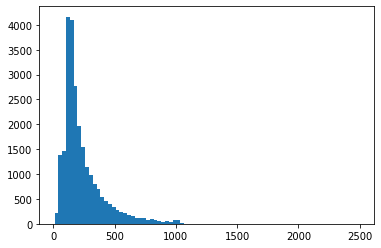

In [11]:
# solution is padding all sequences to the maximum length.
# first find the maximum length
sequence_lengths = [len(sequence) for sequence in train_sequences]
max_len = max(sequence_lengths)
max_len

plt.hist(sequence_lengths, bins=80)
plt.show()

In [57]:
# luckily there is a convenient function for padding
train_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_len)

In [59]:
train_data = tf.data.Dataset.from_tensor_slices((train_sequences_padded, train_labels))

train_sequences_padded.shape

(25000, 2494)

In [ ]:
sorted(index_to_word.items())[:100]

#Helper Classes

In [2]:
class Dataloader:
  def __init__(self, vocab_size, paddingtype, truncatetype):
    self.vocab_size = vocab_size
    self.paddingtype = paddingtype
    self.truncatetype = truncatetype
  def getMaxLen(self, sequences):
    return max([len(sequence) for sequence in sequences])
  
  def padSequences(self, sequences, max_len):
    return tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len, padding=self.paddingtype, truncating=truncatetype)
  
  def loadData(self):
    (train_sequences, train_labels), (test_sequences, test_labels) = tf.keras.datasets.imdb.load_data(num_words= self.vocab_size)
    max_len = max(self.getMaxLen(train_sequences), self.getMaxLen(test_sequences))
    train_sequences_padded = self.padSequences(train_sequences, max_len)
    test_sequences_padded = self.padSequences(test_sequences, max_len)
    train_labels = train_labels.reshape(-1).astype(np.int32)
    test_labels = test_labels.reshape(-1).astype(np.int32)

    train_data = tf.data.Dataset.from_tensor_slices((train_sequences_padded, train_labels)).shuffle(50000).batch(128, drop_remainder=True)
    test_data = tf.data.Dataset.from_tensor_slices((test_sequences_padded, test_labels)).batch(128, drop_remainder=True)

    return train_data, train_labels, test_data, test_labels, max_len

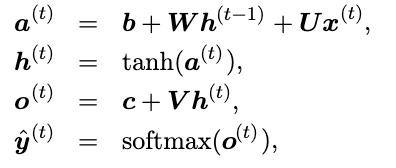

In [3]:
class RNN:
  def __init__(self, hidden_size, vocab_size, learning_rate, max_len):
    self.vocab_size = vocab_size
    self.max_len = max_len
    self.hidden_size = hidden_size
    self.learning_rate = learning_rate
    #input-to-hidden
    self.U = tf.Variable(tf.random.uniform([self.vocab_size, self.hidden_size],minval=-0.1, maxval=0.1,dtype=np.float32))
    #hidden-to-output
    self.V = tf.Variable(tf.random.uniform([self.hidden_size, 2],minval=-0.1, maxval=0.1, dtype=np.float32))
    #hidden-to-hidden
    self.W = tf.Variable(tf.random.uniform([self.hidden_size, self.hidden_size],minval=-0.1, maxval=0.1, dtype=np.float32))
    #hidden layer bias
    self.b = tf.Variable(np.zeros((1, self.hidden_size), dtype=np.float32))
    #output layer bias
    self.c = tf.Variable(np.zeros((128, 2), dtype=np.float32))
    # Prepare the metrics.
    self.train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    #Optimizer
    self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
    self.loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
  def train(self, train_data, epochs):
    for epoch in range(epochs):
      print("Epoch: {}".format(epoch))
      for step, (sequence_batch, label_batch) in enumerate(train_data):
        self.run_step(step, sequence_batch, label_batch, "train")
  
  def evaluate(self, test_data):
    testAcc = []
    for step, (sequence_batch, label_batch) in enumerate(test_data):
        testAcc.append(self.run_step(step, sequence_batch, label_batch, "test"))

    print("Final Test Accuracy Average: {} ".format(sum(testAcc)/len(testAcc)))
  
  def run_step(self, step, sequences, labels, tag):
    with tf.GradientTape() as tape:
        logits = self.rnn_loop(sequences)
        loss = self.loss_fn(labels, logits)
    
    if tag == "train":
      gradient = tape.gradient(loss, [self.U,self.V,self.W,self.b,self.c])
      self.optimizer.apply_gradients(zip(gradient, [self.U,self.V,self.W,self.b,self.c]))


      if not step % 50:
          print("Steps Completed: ", step)
          preds = tf.argmax(logits, axis=1, output_type=tf.int32)
          acc = tf.reduce_mean(tf.cast(tf.equal(preds, labels), tf.float32))
          print("Loss: {} Accuracy: {}".format(loss, acc))
    else:
      preds = tf.argmax(logits, axis=1, output_type=tf.int32)
      acc = tf.reduce_mean(tf.cast(tf.equal(preds, labels), tf.float32))
      return acc
  
  def rnn_loop(self, sequences):
    old_state = np.zeros((1, self.hidden_size), dtype=np.float32)
  
    for step in range(self.max_len):
        x_t = sequences[:, step]
        x_t = tf.one_hot(x_t, depth=vocab_size)
        new_state = np.tanh(self.b + tf.matmul(old_state, self.W) + tf.matmul(x_t, self.U))

        old_state = new_state

    o_t = tf.nn.softmax(tf.matmul(old_state, self.V) + self.c)

    return o_t

#Model_1
num_words = 20000

In [12]:
vocab_size = 20000
paddingtype = "pre"
truncatetype = "pre"
# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
learning_rate = 1e-1
steps = 1000

dataloader = Dataloader(vocab_size, paddingtype, truncatetype)
train_data, train_labels, test_data, test_labels, max_len = dataloader.loadData()


In [15]:
rnn = RNN(hidden_size, vocab_size, learning_rate, max_len)
rnn.train(train_data, epochs=1)

Epoch: 0
Steps Completed:  0
Loss: 0.6931379437446594 Accuracy: 0.546875
Steps Completed:  50
Loss: 0.6936010122299194 Accuracy: 0.5078125
Steps Completed:  100
Loss: 0.693393349647522 Accuracy: 0.5078125
Steps Completed:  150
Loss: 0.7022981643676758 Accuracy: 0.5


In [16]:
rnn.evaluate(test_data)

Final Test Accuracy Average: 0.5129006505012512 


#Model_2

In [4]:
vocab_size = 20000
paddingtype = "post"
truncatetype = "pre"
# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
learning_rate = 1e-1
steps = 1000

dataloader = Dataloader(vocab_size, paddingtype, truncatetype)
train_data, train_labels, test_data, test_labels, max_len = dataloader.loadData()

17473536/17464789 [==============================] - 0s 0us/step


In [5]:
rnn = RNN(hidden_size, vocab_size, learning_rate, max_len)
rnn.train(train_data, epochs=3)

Epoch: 0
Steps Completed:  0
Loss: 0.693108081817627 Accuracy: 0.5078125
Steps Completed:  50
Loss: 0.6919847726821899 Accuracy: 0.5546875
Steps Completed:  100
Loss: 0.7120752930641174 Accuracy: 0.46875
Steps Completed:  150
Loss: 0.6999703049659729 Accuracy: 0.5
Epoch: 1
Steps Completed:  0
Loss: 0.7104418277740479 Accuracy: 0.4765625
Steps Completed:  50
Loss: 0.7059086561203003 Accuracy: 0.5078125
Steps Completed:  100
Loss: 0.7176504731178284 Accuracy: 0.4609375
Steps Completed:  150
Loss: 0.6956782937049866 Accuracy: 0.5234375
Epoch: 2
Steps Completed:  0
Loss: 0.6951822638511658 Accuracy: 0.5625
Steps Completed:  50
Loss: 0.7276246547698975 Accuracy: 0.453125
Steps Completed:  100
Loss: 0.7028472423553467 Accuracy: 0.5
Steps Completed:  150
Loss: 0.7291269302368164 Accuracy: 0.4453125


In [6]:
rnn.evaluate(test_data)

Final Test Accuracy Average: 0.4947916567325592 


#Model_3

In [4]:
vocab_size = 300
paddingtype = "post"
truncatetype = "post"
# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
learning_rate = 0.001
steps = 1000

dataloader = Dataloader(vocab_size, paddingtype, truncatetype)
train_data, train_labels, test_data, test_labels, max_len = dataloader.loadData()

17473536/17464789 [==============================] - 0s 0us/step


In [5]:
rnn = RNN(hidden_size, vocab_size, learning_rate, max_len)
rnn.train(train_data, epochs=3)

Epoch: 0
Steps Completed:  0
Loss: 0.6923080086708069 Accuracy: 0.53125
Steps Completed:  50
Loss: 0.692664623260498 Accuracy: 0.53125
Steps Completed:  100
Loss: 0.6932547092437744 Accuracy: 0.5078125
Steps Completed:  150
Loss: 0.6934694647789001 Accuracy: 0.4765625
Epoch: 1
Steps Completed:  0
Loss: 0.6941149234771729 Accuracy: 0.4765625
Steps Completed:  50
Loss: 0.6934212446212769 Accuracy: 0.53125
Steps Completed:  100
Loss: 0.6959715485572815 Accuracy: 0.4609375
Steps Completed:  150
Loss: 0.6949845552444458 Accuracy: 0.3984375
Epoch: 2
Steps Completed:  0
Loss: 0.6945968866348267 Accuracy: 0.4765625
Steps Completed:  50
Loss: 0.6915712356567383 Accuracy: 0.578125
Steps Completed:  100
Loss: 0.6921217441558838 Accuracy: 0.578125
Steps Completed:  150
Loss: 0.6940472722053528 Accuracy: 0.4609375


In [6]:
rnn.evaluate(test_data)

Final Test Accuracy Average: 0.4991185963153839 


# Questions

# Q1

Question:



*   In the notebook, this is done in a rather crude way: All sequences are padded to the length of the longest sequence in the dataset.
*   Why is this wasteful? Can you think of a smarter padding scheme that is more efficient? Consider the fact that RNNs can work on arbitrary sequence lengths, and that training minibatches are pretty much independent of each other

Answer: 



*   Because as per the histogram plot in the above plots, we can see that most of the sequence lengths are between 0-500 and if we pad to the max length then most of the neurons are initialised with dummy values which is wasteful for computation.
*   Alternative way is to pad at batch level by taking the average length of sequences in that particular batch or truncate all sequences to some length like 500 and pad.





# Q2

Question: Between truncating long sequences and removing them, which option do you think is better? Why?

Answer: Post trunctaing could be better, but here tried different configs with both pre and post truncating but the results are same.





# Q3

Question: Can you think of a way to avoid the one-hot vectors completely? Even if you cannot implement it, a conceptual idea is fine.

Answer: Embeddings.





# Q4

Question: How can it be that we can choose how many outputs we have, i.e. how can both be correct? Are there differences between both choices as well as (dis)advantages relative to each other?

Answer: 



*   Use softmax if the output neurons size is 2 and whichever wins will be the target
*   Use sigmoid if the output neuron size is 1 and get a value, based on the value classify it as 0 or 1 ( by threshold of 0.5)







# Q5

Question: All sequences start with the same special “beginning of sequence” token (coded by index 1). Given this fact, is there a point in learning an initial state? Why (not)?

Answer: Same information might be travelled from the initial state to the next states for every sequence which might not be helpful for classification purpose.





# Q6

Question: pad_sequences allows for pre or post padding. Try both to see the difference. Which option do you think is better? Recall that we use the final time step output from our model.

Answer: By Naive assumption post padding is correct as you might start by not learning anything at beginning if it is pre-pad, but in the different configs performed there is no much difference w.r.t accuracy.





# Q7

Question: Can you think of a way to prevent the RNN from computing new states on padded time steps? One idea might be to “pass through” the previous state in case the current time step is padding. Note that, within a batch, some sequences might be padded for a given time step while others are not.

Answer: 



*   May be instead of setting max lenth sequence at global level for the entire dataset. We can set the max length of the sequence at batch level since RNN can accept different length of time steps. By taking the average length in the current batch sequences and then apply truncation, padding followed by. But here we need to compute the tensors at batch level which will be time consuming.
*   The above description might not prevent padding at all, we can go by sequence by sequence then no need to pad. Now here it is too much time consuming.







# Q8

Question: What could be the advantage of using methods like the above? What are disadvantages? Can you think of other methods to incorporate the full output sequence instead of just the final step?

Answer: We can have output units at each time step and before sending it to the loss function take average of all the output units and send them.





# References


1.   https://towardsdatascience.com/a-beginners-guide-on-sentiment-analysis-with-rnn-9e100627c02e
2.   https://www.deeplearningbook.org/contents/rnn.html
3.   https://ovgu-ailab.github.io/idl2021/assignments/5/rnns_part1.ipynb
4.   https://towardsdatascience.com/recurrent-neural-networks-rnns-3f06d7653a85

